# Sentiment analysis and topic modeling

## Sentiment analysis and EDA
> Here we are using the feel it emotion analysis on the whole longcovid twitter dataset. Next, we are applying some basic EDA 

## Topic modeling
> Topic modeling part is based on this [notebook](https://github.com/gsarti/svevo-letters-analysis/blob/master/topic_modeling.ipynb)     
**Aim:** using this comprehensive notebook that deals with LDA for italian language. The only difference is that this notebook is based on long documents. These are mainly letters. 

another useful [blog](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

In [1]:
# General
import string
import numpy as np
import pandas as pd
import glob
import os

# Gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, KeyedVectors
# from gensim.models.wrappers import LdaMallet   #deprecated. may use https://github.com/maria-antoniak/little-mallet-wrapper/blob/master/demo.ipynb
from gensim.test.utils import datapath

#stop words 
from stop_words import get_stop_words
from wordcloud import WordCloud


# Lemmatization
import spacy

# Silhouette index and shuffle method
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import shuffle

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline


## import 

In [2]:
# all_files = glob.glob(os.path.join("data*"))

# data = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [3]:
path = "../../data/"

In [4]:
data = pd.read_csv(path + 'twint_emotion.csv', index_col = 0)

In [33]:
data.drop(columns = ['Unnamed: 0.1'], inplace = True)

In [5]:
sentiment_counts = data.groupby(['emotion']).size()
print(sentiment_counts)

emotion
anger       8280
fear       10454
joy         2203
sadness     4215
dtype: int64


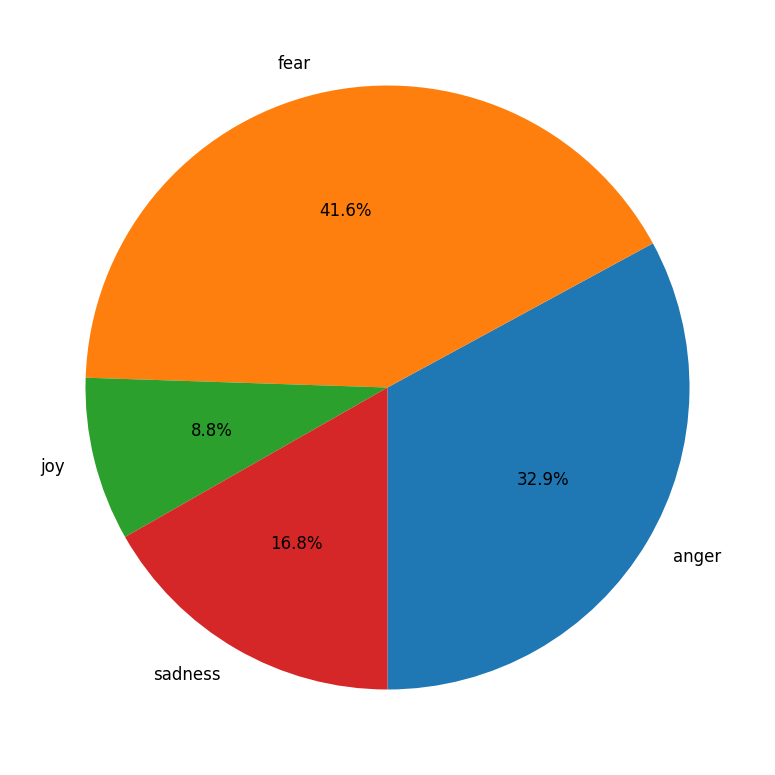

In [6]:
fig = plt.figure(figsize=(10,10), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="");

In [7]:
# ! pip install stop-words

In [8]:
stop = get_stop_words('italian')

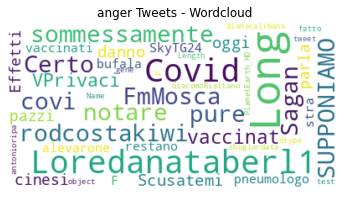

In [9]:
 # Wordcloud with anger tweets
angry_tweets = data['tweet'][data["emotion"] == 'anger']
stop_words = ["https", "co", "RT"] + list(stop)
anger_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(angry_tweets))
plt.figure()
plt.title("anger Tweets - Wordcloud")
plt.imshow(anger_wordcloud, interpolation="bilinear")
plt.axis("off");

NameError: name 'negative_wordcloud' is not defined

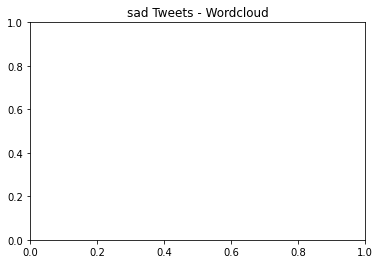

In [10]:
# Wordcloud with sad tweets
sad_tweets = data['tweet'][data["emotion"] == 'sadness']
stop_words = ["https", "co", "RT"] + list(stop)
sad_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(sad_tweets))
plt.figure()
plt.title("sad Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off");

In [ ]:
 # Wordcloud with joy tweets
joy_tweets = data['tweet'][data["emotion"] == 'joy']
stop_words = ["https", "co", "RT"] + list(stop)
joy_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(joy_tweets))
plt.figure()
plt.title("joy Tweets - Wordcloud")
plt.imshow(joy_wordcloud, interpolation="bilinear")
plt.axis("off");

In [ ]:
 # Wordcloud with fear tweets
fear_tweets = data['tweet'][data["emotion"] == 'fear']
stop_words = ["https", "co", "RT"] + list(stop)
fear_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(fear_tweets))
plt.figure()
plt.title("fear Tweets - Wordcloud")
plt.imshow(fear_wordcloud, interpolation="bilinear")
plt.axis("off");

In [11]:
data.columns

Index(['Unnamed: 0.1', 'id', 'conversation_id', 'created_at', 'date', 'time',
       'timezone', 'user_id', 'username', 'name', 'place', 'tweet', 'language',
       'mentions', 'urls', 'photos', 'replies_count', 'retweets_count',
       'likes_count', 'hashtags', 'cashtags', 'link', 'retweet', 'quote_url',
       'video', 'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'emotion'],
      dtype='object')

Questions to ask 

- Do the feelings differ with time regarding long covid?

- which emotions within the tweets get the highest likes? 

- what are the most common hashtags? 

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [13]:
number_tweets_per_day = data.groupby(['date', 'emotion']).agg({'id': 'count'}).reset_index()

In [14]:
number_tweets_per_day["tweet_date"] = pd.to_datetime(number_tweets_per_day["date"])

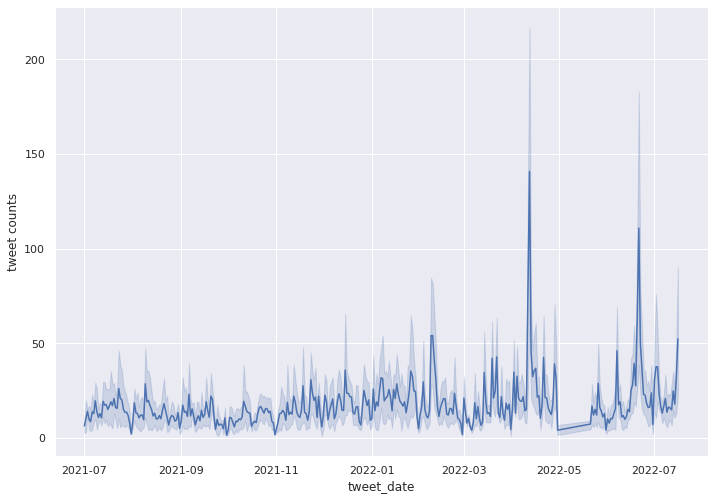

In [15]:
sns.lineplot(data = number_tweets_per_day, x = 'tweet_date', y = 'id')
plt.ylabel('tweet counts');

Awareness slightly increasing with time. There are some peaks of attention to long covid. What are the sentiments for these peaks? 

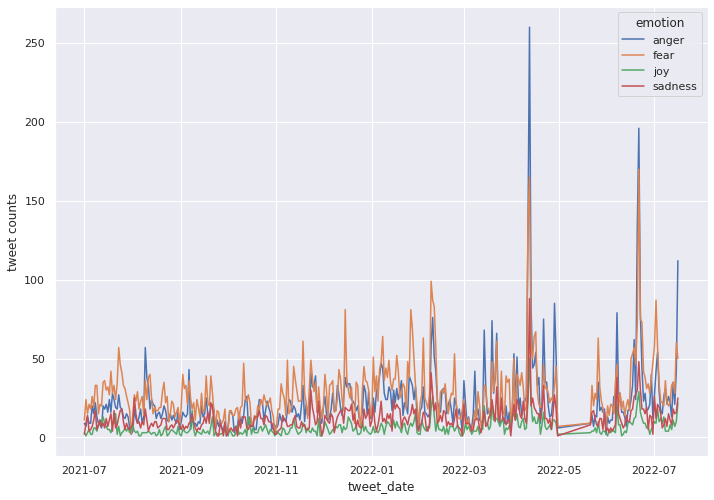

In [16]:
sns.lineplot(data = number_tweets_per_day, x = 'tweet_date', y = 'id', hue = 'emotion')
plt.ylabel('tweet counts');

As expected, the two peaks around April 22 and June 22 have the emotions anger and fear as the highest emotions. 
Moreover, it seems that joy is almost always absent. In general, it seems that fear is dominating throughout the whole period, except for the major peaks where anger dominates.

## Which emotions cause on average the highest likes? 

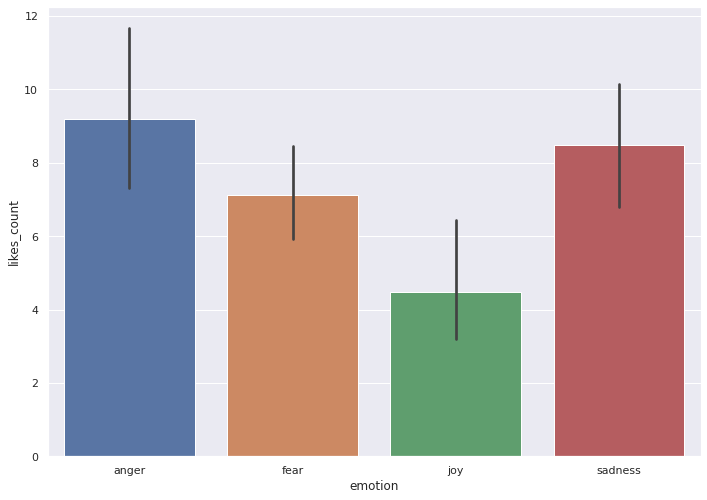

In [17]:
sns.barplot(data = data, x = 'emotion', y = 'likes_count');

Fear and saddness give the highest likes. This is regardless the fact that anger and fear are the most common emotions as shown below

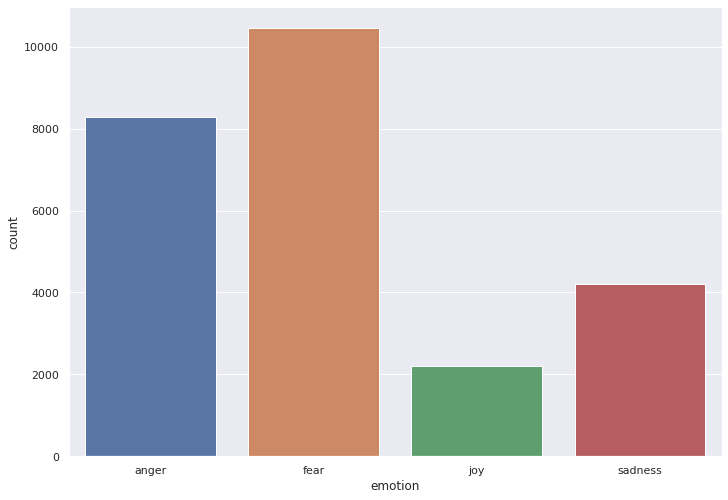

In [18]:
sns.countplot(data = data, x = 'emotion');

## What are the most common hashtags

In [19]:
# data.hashtags.str.split(',')
hashtag_list = []

for i in data.hashtags:
    for j in i.split(','):
        hashtag_list.append(j.strip('[]').strip(' '))

In [20]:
hashtag_list = list(filter(None, hashtag_list))

In [21]:
from collections import Counter as c

In [22]:
hash_counts = c(hashtag_list)

In [23]:
most_common_hash = hash_counts.most_common(30)

### A bar chart for the most common hashtags

In [24]:
labels, ys = zip(*most_common_hash)

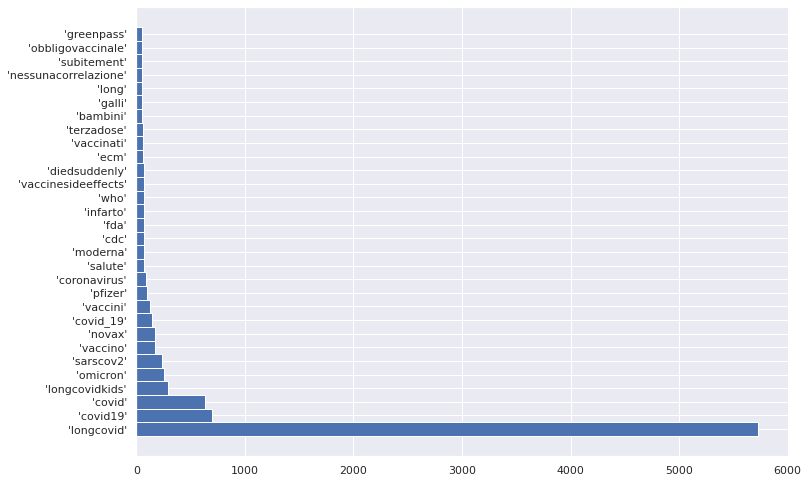

In [25]:
labels, ys = zip(*most_common_hash)
xs = np.arange(len(labels)) 
width = 1

plt.barh(xs, ys, width, align='center')

plt.yticks(xs, labels); #Replace default x-ticks with xs, then replace xs with labels

## Topic modeling

In [26]:
nlp_it = spacy.load("it", disable=['parser', 'ner'])

In [27]:
# Language dictionary for scipy language format
dict_spacy = {"ITA" : nlp_it}

In [28]:
# Custom stopwords for our purposes
# stop_words = set(['schmitz', 'signore', 'signora', 'mano', 'ettore', 'lettera', 'parola', 'fare', 'cosa'])
# Enables pyLDAvis visualization for the notebook
pyLDAvis.enable_notebook()

## Custom NLP toolbox

In [30]:
def tokenize(texts):
    """
    Tokenizes a list of texts, returning a list of tokens.
    """
    token_texts = []
    for text in texts:
        token_texts.append(simple_preprocess(text, deacc=True))
    return token_texts
     
def preprocess_text(text, nlp, stop_words = [], pos = ['PROPN', 'NOUN', 'VERB', 'ADJ']):
    """
    Performs preprocessing on a text through spaCy, langauge based on nlp parameter.
    Filter default stopword plus those in the list stop_words,
    accepts only word with POS tag in the pos list,
    filters out non-alpha words, performs lemmatization.
    Returns a list of lemmatized, filtered tokens for the text.
    """
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if token.lemma_ not in stop_words and token.pos_ in pos and not token.is_stop and token.is_alpha:
            tokens.append(token.lemma_)
    return tokens

def create_lda_model(dictionary, corpus, num_topics, num_words = 20, passes = 20):
    """
    Creates an LDA model using gensim.
    Dictionary and corpus should be obtained with corpora.
    Number of topics and number of passes should be tweaked depending on context.
    """
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)
    for topic,words in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=num_words):
        print(str(topic)+ ": " + words + "\n")
    return lda_model

def get_lda_keywords(model, num_words = 20):
    """
    Extract the firt num_words keywords from all topics of a gensim LDA model.
    """
    num_topics = len(model.print_topics())
    return [[tup2[0] for tup2 in tup[1]]for tup in model.show_topics(formatted=False, num_topics=num_topics, num_words=num_words)]
    
def create_paper_points_data(lda_model, corpus, num_topics):
    """
    Creates a dataframe with topic scores for each text in corpus using a gensim LDA model.
    """
    x = [[] for i in range(num_topics)]
    for text in corpus:
        l_tup = lda_model[text]
        for val in range(num_topics):
            added = False
            for tup in l_tup:
                if tup[0] == val:
                    x[val].append(tup[1])
                    added = True
            if added == False:
                x[val].append(0)
    df = pd.DataFrame(x)
    df = df.transpose()
    df.columns = ['Topic' + str(n) for n in range(num_topics)]
    return df

def compute_silhouette(lda_model, corpus, num_topics):
    """
    Computes silhouette index for an LDA model based on topics it classified.
    """
    points = create_paper_points_data(lda_model, corpus, num_topics).values
    lda_labels = points.argmax(axis=1) 
    return silhouette_score(points, lda_labels)
    
def compute_perplexity(lda_model, corpus):
    """
    Computes perplexity score for an LDA model.
    """
    perplexity = lda_model.log_perplexity(corpus)
    return perplexity

def compute_coherence(lda_model, texts, corpus, dictionary, coherence = "c_v"):
    """
    Computes coherence score for an LDA model.
    """
    score = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence=coherence).get_coherence()
    return score

def assess_model_goodness(lda_model, texts, corpus, dictionary, num_topics):
    """
    Assess the goodness of an LDA model using coherence and silhouette scores.
    """
    points = create_paper_points_data(lda_model, corpus, num_topics).values
    lda_labels = points.argmax(axis=1)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(points) + (n + 1) * 10])
    silhouette_avg = silhouette_score(points, lda_labels)
    print("For {} topic the average silhouette score is : {}\n".format(num_topics, silhouette_avg))
    #print("Perplexity: {}\n".format(compute_perplexity(lda_model, corpus)))
    print("Coherence: {}\n".format(compute_coherence(lda_model, texts, corpus, dictionary, "c_v")))
    sample_silhouette_values = silhouette_samples(points, lda_labels)
    y_lower = 10
    for i in range(num_topics):
        ith_topic_silhouette_values = sample_silhouette_values[lda_labels == i]
        ith_topic_silhouette_values.sort()
        size_topic_i = ith_topic_silhouette_values.shape[0]
        y_upper = y_lower + size_topic_i
        color = cm.nipy_spectral(float(i) / num_topics)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_topic_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_topic_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title("Silhouette plot for " + str(num_topics) + " topics.")
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Topic number")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

def assess_model_certainity(lda_model, corpus, num_topics, low_bound = 0.20, up_bound = 0.80):
    """
    Assess the certainity of assignation of textes in a corpus to a certain topic based on pre-defined bounds.
    """
    n = 0
    c_topics = []
    f_topics = []
    f_topics_bad = []
    f_topics_good = []
    sum_bad = 0
    for text in corpus:
        c_topics.append((lda_model[text], n))
        n += 1 
    print("Total texts:", len(c_topics))
    for n in range(num_topics):
        f_topics.append([[(tup[1], t[0], t[1]) for t in tup[0] if t[0] == n] for tup in c_topics])
        f_topics[n] = [x for x in f_topics[n] if x != []]
        print("Texts with topic", n, "assigned:", len(f_topics[n]))
        f_topics_bad.append([x for x in f_topics[n] if x[0][2] > low_bound and x[0][2] < up_bound])
        print("Texts with topic", n, " uncertainly assigned:", len(f_topics_bad[n]))
        f_topics_good.append([x for x in f_topics[n] if x[0][2] > up_bound])
        print("Texts with topic", n, " prevalent:", len(f_topics_good[n]))        
        sum_bad += len(f_topics_bad[n])
    print("Total uncertain texts:", sum_bad)
    print("Uncertainty percentage:", float(sum_bad) / float(len(c_topics)))
    good_text_ids = [[x[0][0] for x in topic] for topic in f_topics_good]
    bad_text_ids = [[x[0][0] for x in topic] for topic in f_topics_bad]
    return good_text_ids, bad_text_ids

def remove_stopwords(text, language, stop_words = []):
    nlp = spacy.load(language, disable=['parser', 'ner'])
    doc = nlp(text.lower())
    filtered = []
    for token in doc:
        if token.text not in stop_words and token.is_alpha and not token.is_stop:
            filtered.append(token)
    return " ".join([token.text for token in filtered])

def lemmatize_pos_filter(text, language, pos):
    nlp = spacy.load(language, disable=['parser', 'ner'])
    doc = nlp(text.lower())
    filtered = []
    for token in doc:
        if token.pos_ in pos:
            filtered.append(token)
    return [token.lemma_ for token in filtered]
    
def generate_ngrams(text, bigram, trigram, is_token = False):
    if is_token:
        token_texts = text
    else:
        token_texts = tokenize(text)
    return trigram[bigram[token_texts]]
    
def preprocess_text_ngrams(text, language, stop_words = [], pos = ['PROPN', 'NOUN', 'VERB', 'ADJ'], ngrams = False, bigram = None, trigram = None):
    text = remove_stopwords(text, language, stop_words)
    if ngrams and bigram and trigram:
        tokens = generate_ngrams(text, bigram, trigram)
    print(tokens.corpus)
    return lemmatize_pos_filter(" ".join(tokens), language, pos)


In [31]:
data.head()

,Unnamed: 0.1,id,conversation_id,created_at,date,time,timezone,user_id,username,name,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,emotion
0,10988,1513808669309341696,1513753027504660483,2022-04-12 14:48:06 India Standard Time,2022-04-12,14:48:06,530,1062444987542130689,mottinipaolo,Paolo 🇮🇹🇪🇺,...,NaN,NaN,NaN,NaN,"[{'screen_name': 'FmMosca', 'name': 'Francesco...",NaN,NaN,NaN,NaN,anger
1,10989,1513808321261748224,1513808321261748224,2022-04-12 14:46:43 India Standard Time,2022-04-12,14:46:43,530,128860907,corrierecitta,Il Corriere della Città,...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,fear
2,10990,1513808255713263618,1513472929052315652,2022-04-12 14:46:28 India Standard Time,2022-04-12,14:46:28,530,1419298742386180097,catysan21,Alias JuliaSmith📕,...,NaN,NaN,NaN,NaN,"[{'screen_name': 'rodcostakiwi', 'name': 'Rodo...",NaN,NaN,NaN,NaN,fear
3,10991,1513807833271308289,1513485831335514118,2022-04-12 14:44:47 India Standard Time,2022-04-12,14:44:47,530,1234480280993484800,alberto45109828,☄️Alberto🦧sukami stà Z!,...,NaN,NaN,NaN,NaN,"[{'screen_name': 'rodcostakiwi', 'name': 'Rodo...",NaN,NaN,NaN,NaN,anger
4,10992,1513807604245536773,1513807604245536773,2022-04-12 14:43:52 India Standard Time,2022-04-12,14:43:52,530,1296134026282115077,italicatestudo,Testuggine🛡,...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,anger


## Topic Modeling with LDA

We then created a range of LDA models with 1-10 topics and assessed their goodness using our custom evaluation functions.

In [ ]:
def remove_content(text):
    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) #remove urls
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags

In [35]:
texts_it = [preprocess_text(text, nlp_it, stop_words=stop_words, pos = ['PROPN', 'NOUN']) for text in data["tweet"]]
texts_it = [remove_content(text_it) for text in text_it]
d_it = corpora.Dictionary(texts_it)
d_it.filter_extremes(no_below=5, no_above=0.5)
c_it = [d_it.doc2bow(text) for text in texts_it]

In [ ]:
from tqdm import tqdm
n_topics = 5
models_it = []
for n in tqdm(range(2, n_topics)):
    model_it = create_lda_model(d_it, c_it, n, passes = 10)
    assess_model_goodness(model_it, texts_it, c_it, d_it, n)
    models_it.append(model_it)

silhouette_list = [compute_silhouette(model_it, c_it, len(model_it.print_topics())) for model_it in models_it]
perplexity_list = [compute_perplexity(model_it, c_it) for model_it in models_it]
coh_v = [compute_coherence(model_it, texts_it, c_it, d_it, coherence = "c_v") for model_it in models_it]

x = range(2,n_topics)
plt.plot(x, coh_v)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()
plt.plot(x, silhouette_list)
plt.xlabel("Num Topics")
plt.ylabel("Silhouette index")
plt.show()

  0%|                                                     | 0/3 [00:00<?, ?it/s]

0: 0.070*"longcovid" + 0.049*"vaccinare" + 0.041*"effetto" + 0.020*"virus" + 0.016*"vaccino" + 0.015*"infezione" + 0.013*"termine" + 0.012*"rischiare" + 0.012*"problema" + 0.012*"caso" + 0.012*"danno" + 0.011*"dato" + 0.010*"omicron" + 0.010*"morto" + 0.010*"conseguenza" + 0.009*"italia" + 0.008*"paziente" + 0.008*"studio" + 0.007*"variare" + 0.007*"vaccinazione"

1: 0.044*"longcovid" + 0.038*"sintomo" + 0.035*"bambino" + 0.027*"malattia" + 0.014*"problema" + 0.011*"studiare" + 0.011*"rischiare" + 0.011*"ospedale" + 0.010*"paziente" + 0.010*"giovane" + 0.007*"morto" + 0.007*"età" + 0.007*"patologia" + 0.007*"influenzare" + 0.006*"settimana" + 0.006*"gente" + 0.006*"terapia" + 0.006*"sindrome" + 0.006*"danno" + 0.005*"colpa"

For 2 topic the average silhouette score is : 0.5973843336105347



Process AccumulatingWorker-14:
Process AccumulatingWorker-12:
Process AccumulatingWorker-9:
Process AccumulatingWorker-13:
Process AccumulatingWorker-10:
Process AccumulatingWorker-8:
Process AccumulatingWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hamza/anaconda3/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/home/hamza/anaconda3/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/home/hamza/anaconda3/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/home/hamza/anaconda3/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/home/hamza/anaconda3/lib/python3.8/mult

## Ideas for web app

choose a specific date, you will get a number of tweets as well as emotion distribution 